# Causal Inference - Regression Discontinuity Design

## Install requirements

In [2]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Import libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rdd import rdd
import statsmodels.api as sm
import statsmodels.formula.api as smf


from IPython.display import Image, display

import warnings

## SHARP RDD

### SHARP RDD for linear relationship

#### Generate simulated data for linear relationship

In [928]:
# Set random seed for reproducibility
np.random.seed(42)

# Set the number of customers
num_customers = 1000

# Generate random pre-cashback spending with a bias around the threshold
pre_cashback_spending = np.random.normal(loc=2000, scale=200, size=num_customers)

# Determine if customers crossed the cashback threshold
crossed_cashback_threshold = (pre_cashback_spending > 2000).astype(int)

# Generate post-cashback spending with a slight increase for those who crossed the threshold
post_cashback_spending = 1.05 * pre_cashback_spending  + 250 * crossed_cashback_threshold +  np.random.normal(loc=0, scale=100, size=num_customers)

# Create a DataFrame with the simulated data
df = pd.DataFrame({
    "cust_id": range(1, num_customers + 1),
    "pre_spend": pre_cashback_spending,
    "cutoff": crossed_cashback_threshold.astype(int),
    "post_spend": post_cashback_spending
})

display(df)

,cust_id,pre_spend,cutoff,post_spend
0,1,2099.342831,1,2594.245516
1,2,1972.347140,0,2163.427865
2,3,2129.537708,1,2491.977630
3,4,2304.605971,1,2605.142592
4,5,1953.169325,0,2120.650123
...,...,...,...,...
995,996,1943.779941,0,2147.983962
996,997,2359.537305,1,2724.862045
997,998,2128.168572,1,2396.389536
998,999,1885.764202,0,1963.745716


In [930]:
# Simple comparison of means

before_cutoff_mean = df.loc[df["pre_spend"]<2000, "post_spend"].mean()
after_cutoff_mean = df.loc[df["pre_spend"]>2000, "post_spend"].mean()
diff_in_mean = after_cutoff_mean - before_cutoff_mean
print(f"Cashback program increased average customer spending by: USD {np.round(diff_in_mean,2)}")

Cashback program increased average customer spending by: USD 569.62


#### Visualize the linear relationship

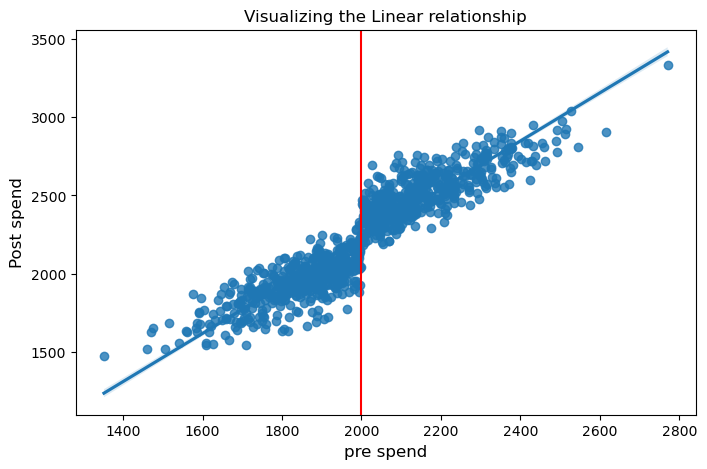

In [933]:
plt.figure(figsize=(8, 5))
# sns.scatterplot(data = df, x = 'pre_spend', y = 'post_spend', hue = 'cutoff');
sns.regplot(data = df, x = 'pre_spend', y = 'post_spend');
plt.axvline(x=2000, color = 'red');
plt.title('Visualizing the Linear relationship')
plt.xlabel('pre spend', fontsize=12)
plt.ylabel('Post spend', fontsize=12)
plt.show()

#### Modeling Linear Relationship using OLS

In [936]:
model1 = smf.ols("post_spend~pre_spend + cutoff",  df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             post_spend   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     4831.
Date:                Sun, 06 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:56:55   Log-Likelihood:                -6020.2
No. Observations:                1000   AIC:                         1.205e+04
Df Residuals:                     997   BIC:                         1.206e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.4780     49.347      0.719      0.472     -61.358     132.314
pre_spend      1.0367      0.027     38.922      0.000       0.984       1.089
cutoff       246.3986     10.430     23.624      0.000     225.931     266.866
==============================================================================
Omnibus:                        0.937   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.626   Jarque-Bera (JB):                0.808
Skew:                          -0.050   Prob(JB):                        0.668
Kurtosis:                       3.098   Cond. No.                     3.19e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [938]:
LATE = model1.params['cutoff']
print(f"Treatment increased average customer spending by: USD {np.round(LATE,2)}")

Treatment increased average customer spending by: USD 246.4


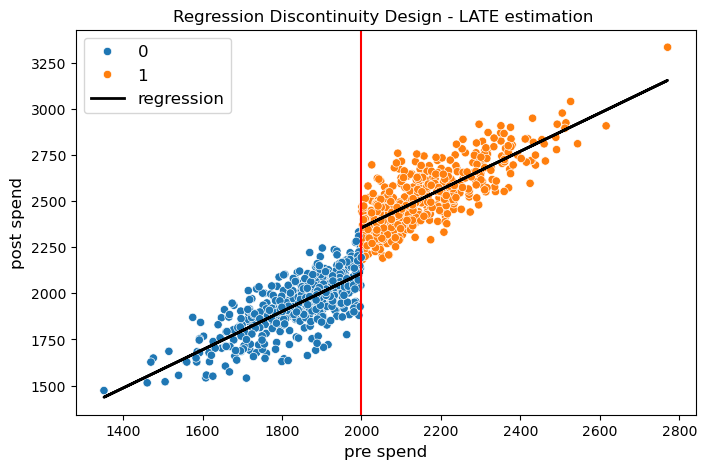

In [942]:

plt.figure(figsize=(8, 5))
sns.scatterplot(data = df, x = 'pre_spend', y = 'post_spend', hue = 'cutoff');
plt.plot(df.query("pre_spend<2000")["pre_spend"], model1.predict(df.query("pre_spend<2000")), color="black", lw=2, label="regression")
plt.plot(df.query("pre_spend>2000")["pre_spend"], model1.predict(df.query("pre_spend>2000")), color="black", lw=2)
plt.axvline(x=2000, color = 'red');
plt.title('Regression Discontinuity Design - LATE estimation ')
plt.xlabel('pre spend', fontsize=12)
plt.ylabel('post spend', fontsize=12)
plt.legend(fontsize=12)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


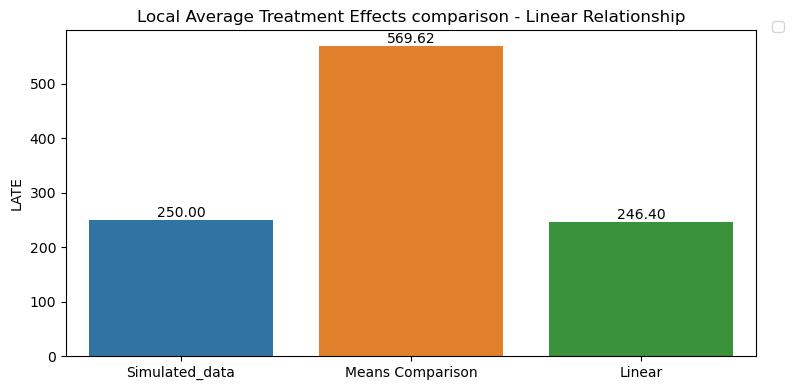

In [859]:
# Plot comparison of results

categories = ['Simulated_data', 'Means Comparison', 'Linear']
plt.figure(figsize = (8,4))
ax = sns.barplot(x=categories, y=[250, diff_in_mean, ATE], hue = categories)

for p in ax.patches:
    label = "{:.2f}".format(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(label, (x, y), ha="center", va="center", 
                size=10, xytext=(0, 5), textcoords="offset points",) 
    
plt.ylabel('LATE')
plt.title('Local Average Treatment Effects comparison - Linear Relationship')
plt.legend(bbox_to_anchor = (1.05, 1.05))
plt.tight_layout()
plt.show()

### SHARP RDD for Non linear relationship

#### Generate simulated data for Non-Linear relationship

In [944]:
# Set random seed for reproducibility
np.random.seed(42)

# Set the number of customers
num_students = 1000

# Generate random score with a bias around the threshold
score = np.random.normal(loc=100, scale=50, size=num_customers)

# Determine if customers crossed the cashback threshold
threshold = (score > 140).astype(int)

salary = 1.05 * score + score**2 
salary = salary +  2500 * threshold + np.random.normal(loc=0, scale=1000, size=num_students)

# Create a DataFrame with the simulated data
df2 = pd.DataFrame({
    "student": range(1, num_customers + 1),
    "score": score,
    "cutoff": threshold,
    "salary": salary
})

df2 = df2[(df2.score>25) & (df2.score<250) ].copy()

display(df2)

,student,score,cutoff,salary
0,1,124.835708,0,17114.386834
1,2,93.086785,0,9687.524338
2,3,132.384427,0,17724.270505
3,4,176.151493,1,33067.370713
4,5,88.292331,0,8586.466021
...,...,...,...,...
995,996,85.944985,0,8546.932981
996,997,189.884326,1,38728.914674
997,998,132.042143,0,16691.897144
998,999,71.441051,0,5015.769837


In [946]:
# Simple comparison of means

before_cutoff_mean = df2.loc[df2["score"]<140, "salary"].mean()
after_cutoff_mean = df2.loc[df2["score"]>140, "salary"].mean()
diff_in_mean = after_cutoff_mean - before_cutoff_mean
print(f"Admission in top universities increased average salary by: USD {np.round(diff_in_mean,2)}")

Admission in top universities increased average salary by: USD 22718.1


#### Visualize the Non-Linear relationship

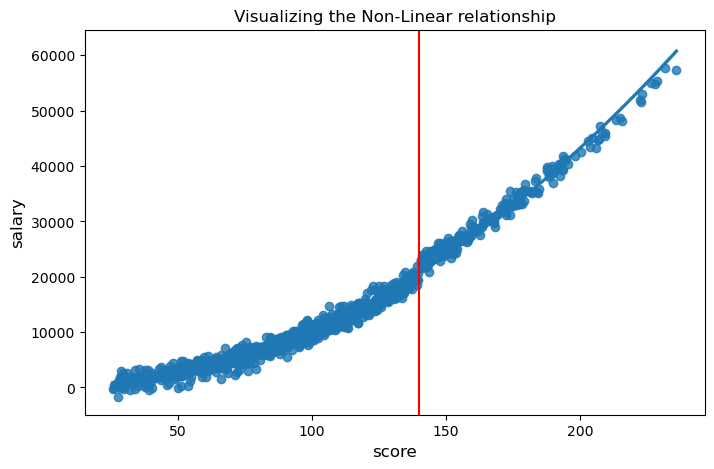

In [949]:
plt.figure(figsize=(8, 5))
sns.regplot(data = df2, x = 'score', y = 'salary', order = 2);
plt.axvline(x=140, color = 'red');
plt.title('Visualizing the Non-Linear relationship')
plt.xlabel('score', fontsize=12)
plt.ylabel('salary', fontsize=12)
plt.show()

#### Modeling Non-Linear Relationship using OLS

In [952]:
model2 = smf.wls("salary ~ score + cutoff",  df2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.959
Model:                            WLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Sun, 06 Oct 2024   Prob (F-statistic):               0.00
Time:                        19:15:26   Log-Likelihood:                -8598.4
No. Observations:                 941   AIC:                         1.720e+04
Df Residuals:                     938   BIC:                         1.722e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -8505.8653    243.475    -34.935      0.000   -8983.684   -8028.047
score        196.6211      2.563     76.703      0.000     191.590     201.652
cutoff      7044.0934    271.809     25.916      0.000    6510.670    7577.517
==============================================================================
Omnibus:                      319.330   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1532.749
Skew:                           1.498   Prob(JB):                         0.00
Kurtosis:                       8.488   Cond. No.                         512.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [954]:
Two_LATE1 = model2.params['cutoff']
print(f"Treatment increased average salary by: USD {np.round(Two_LATE1,2)}")

Treatment increased average salary by: USD 7044.09


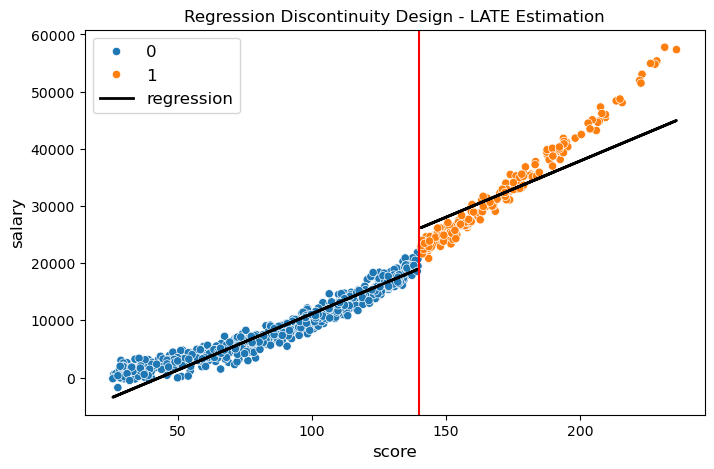

In [956]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data = df2, x = 'score', y = 'salary', hue = 'cutoff');
plt.plot(df2.query("score<140")["score"], model2.predict(df2.query("score<140")), color="black", lw=2, label="regression")
plt.plot(df2.query("score>140")["score"], model2.predict(df2.query("score>140")), color="black", lw=2)
plt.axvline(x=cutoff2, color = 'red');
plt.title('Regression Discontinuity Design - LATE Estimation')
plt.xlabel('score', fontsize=12)
plt.ylabel('salary', fontsize=12)
plt.legend(fontsize=12)
plt.show()

#### Local Linear Regression using RDD package

In [959]:
bandwidth_opt = rdd.optimal_bandwidth(df2['salary'], df2['score'], cut=cutoff2)
print("Optimal bandwidth:", bandwidth_opt)

Optimal bandwidth: 45.46418211514328


In [961]:
data_rdd = rdd.truncated_data(df2, 'score', bandwidth_opt, cut=cutoff2)

In [963]:
model3 = rdd.rdd(data_rdd, 'score', 'salary', cut=cutoff2).fit() # smf.wls('salary~score + cutoff', data_rdd).fit()
model3.summary()

Estimation Equation:	 salary ~ TREATED + score


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.977
Model:                            WLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 1.055e+04
Date:                Sun, 06 Oct 2024   Prob (F-statistic):               0.00
Time:                        19:15:29   Log-Likelihood:                -4309.6
No. Observations:                 509   AIC:                             8625.
Df Residuals:                     506   BIC:                             8638.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.681e+04    462.449    -36.346      0.000   -1.77e+04   -1.59e+04
TREATED     2967.2988    203.485     14.582      0.000    2567.519    3367.078
score        263.8729      3.955     66.714      0.000     256.102     271.644
==============================================================================
Omnibus:                        7.010   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                7.182
Skew:                           0.285   Prob(JB):                       0.0276
Kurtosis:                       2.886   Cond. No.                     1.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [965]:
Two_LATE2 = model3.params['TREATED']
print(f"Treatment increased average salary by: USD {np.round(Two_LATE2,2)}")

Treatment increased average salary by: USD 2967.3


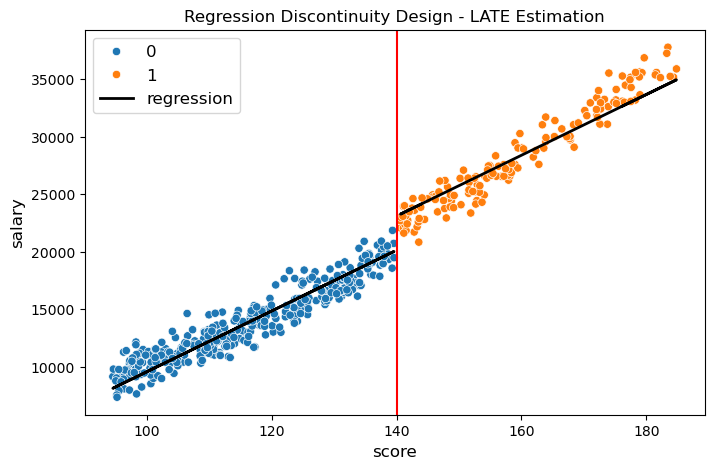

In [967]:

plt.figure(figsize=(8, 5))
sns.scatterplot(data = data_rdd, x = 'score', y = 'salary', hue = 'cutoff');
plt.plot(data_rdd.query("score<140")["score"], model3.predict(data_rdd.query("score<140").rename(columns = {'cutoff' : 'TREATED'})), color="black", lw=2, label="regression")
plt.plot(data_rdd.query("score>140")["score"], model3.predict(data_rdd.query("score>140").rename(columns = {'cutoff' : 'TREATED'})), color="black", lw=2)
plt.axvline(x=140, color = 'red');
plt.title('Regression Discontinuity Design - LATE Estimation')
plt.xlabel('score', fontsize=12)
plt.ylabel('salary', fontsize=12)
plt.legend(fontsize=12)
plt.show()

### Local Linear Regression with triangular kernel weights using RDD

In [970]:
def kernel(x, cut, h):
    """
    Estimates weights using the triangular kernel function.

    Args:
        x: A NumPy array containing the running variable values.
        cut: The threshold value for the regression discontinuity design.
        h: The bandwidth parameter.

    Returns:
        A NumPy array containing the estimated weights.
    """

    x_normalized = x - cut
    weights = np.maximum(1 - np.abs(x_normalized / h), 0)
    return weights

In [972]:
data_rdd = rdd.truncated_data(df2, 'score', bandwidth_opt, cut=cutoff2)

x = data_rdd['score']
y = kernel(data_rdd['score'], cut=cutoff2, h = bandwidth_opt)

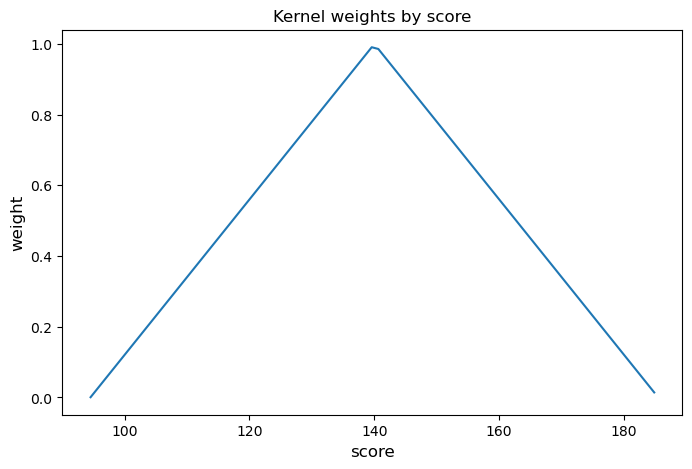

In [974]:
plt.figure(figsize=(8, 5))
sns.lineplot(x=x, y=y)
plt.title('Kernel weights by score')
plt.xlabel('score', fontsize=12)
plt.ylabel('weight', fontsize=12)
plt.show()

In [893]:
model4 = rdd.rdd(data_rdd, 'score', 'salary', cut=cutoff2, weights = kernel(data_rdd['score'], cut=cutoff2, h = bandwidth_opt)).fit()
model4.summary()

Estimation Equation:	 salary ~ TREATED + score


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.967
Model:                            WLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     7326.
Date:                Sun, 06 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:57:26   Log-Likelihood:                -4345.2
No. Observations:                 509   AIC:                             8696.
Df Residuals:                     506   BIC:                             8709.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.787e+04    553.916    -32.267      0.000    -1.9e+04   -1.68e+04
TREATED     2590.6960    162.563     15.937      0.000    2271.314    2910.078
score        270.7840      4.455     60.778      0.000     262.031     279.537
==============================================================================
Omnibus:                        3.057   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.217   Jarque-Bera (JB):                2.864
Skew:                          -0.144   Prob(JB):                        0.239
Kurtosis:                       3.228   Cond. No.                     1.61e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [895]:
Two_LATE3 = model4.params['TREATED']
print(f"Treatment increased average salary by: USD {np.round(Two_LATE3,2)}")

Treatment increased average salary by: USD 2590.7


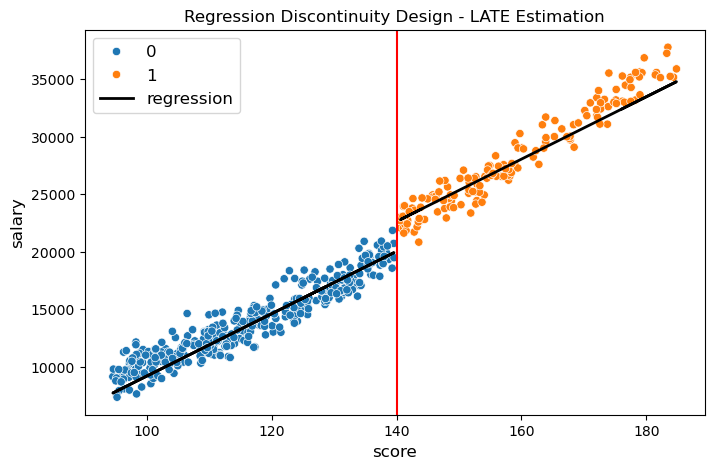

In [897]:

plt.figure(figsize=(8, 5))
sns.scatterplot(data = data_rdd, x = 'score', y = 'salary', hue = 'cutoff');
plt.plot(data_rdd.query("score<140")["score"], model4.predict(data_rdd.query("score<140").rename(columns = {'cutoff' : 'TREATED'})), color="black", lw=2, label="regression")
plt.plot(data_rdd.query("score>140")["score"], model4.predict(data_rdd.query("score>140").rename(columns = {'cutoff' : 'TREATED'})), color="black", lw=2)
plt.axvline(x=140, color = 'red');
plt.title('Regression Discontinuity Design - LATE Estimation')
plt.xlabel('score', fontsize=12)
plt.ylabel('salary', fontsize=12)
plt.legend(fontsize=12)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


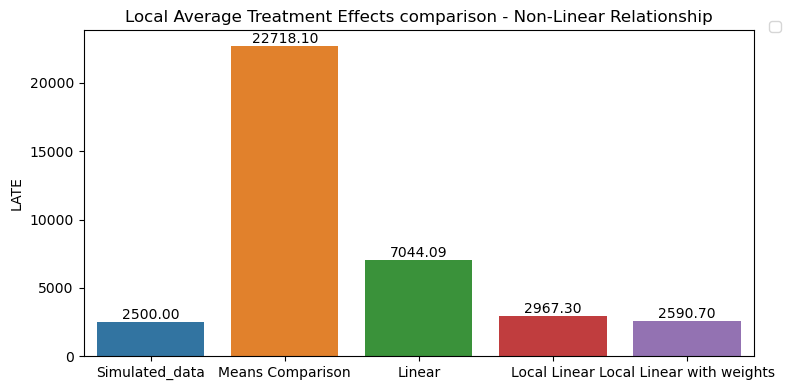

In [899]:
# Plot comparison of results

categories = ['Simulated_data', 'Means Comparison', 'Linear', 'Local Linear', 'Local Linear with weights']
plt.figure(figsize = (8,4))
ax = sns.barplot(x=categories, y=[2500, diff_in_mean, Two_ATE1, Two_ATE2, Two_ATE3], hue = categories)

for p in ax.patches:
    label = "{:.2f}".format(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(label, (x, y), ha="center", va="center", 
                size=10, xytext=(0, 5), textcoords="offset points",) 
    
plt.ylabel('LATE')
plt.title('Local Average Treatment Effects comparison - Non-Linear Relationship')
plt.legend(bbox_to_anchor = (1.05, 1.05))
plt.tight_layout()
plt.show()

## FUZZY RDD

### FUZZY RDD for linear relationship

#### Generate simulated data for Fuzzy RDD - linear relationship¶

In [978]:
# Set random seed for reproducibility
np.random.seed(42)

# Set the number of customers
num_customers = 1000

# Generate random pre-cashback spending with a bias around the threshold
pre_cashback_spending = np.random.normal(loc=2000, scale=200, size=num_customers)

# Determine if customers crossed the cashback threshold
cutoff =  (pre_cashback_spending > 2000).astype(int)
crossed_cashback_threshold = (pre_cashback_spending > 2000).astype(int)

# Introduce a 30% chance of not availing the offer
avail_offer = np.random.choice([0, 1], size=num_customers, p=[0.3, 0.7])
crossed_cashback_threshold *= avail_offer

# Generate post-cashback spending with a slight increase for those who crossed the threshold and availed the offer
post_cashback_spending = 1.05 * pre_cashback_spending + 250 * crossed_cashback_threshold + np.random.normal(loc=0, scale=100, size=num_customers)

# Create a DataFrame with the simulated data
df3 = pd.DataFrame({
    "cust_id": range(1, num_customers + 1),
    "pre_spend": pre_cashback_spending,
    "cutoff": cutoff,
    "post_spend": post_cashback_spending,
    "offer_availed": crossed_cashback_threshold
})

display(df3)

,cust_id,pre_spend,cutoff,post_spend,offer_availed
0,1,2099.342831,1,2173.389064,0
1,2,1972.347140,0,1995.748856,0
2,3,2129.537708,1,2517.932044,1
3,4,2304.605971,1,2803.881314,1
4,5,1953.169325,0,1863.310544,0
...,...,...,...,...,...
995,996,1943.779941,0,1975.992416,0
996,997,2359.537305,1,2357.194085,0
997,998,2128.168572,1,2380.372560,1
998,999,1885.764202,0,1931.332120,0


In [980]:
# Simple comparison of means

before_cutoff_mean = df3.loc[df3["pre_spend"]<2000, "post_spend"].mean()
after_cutoff_mean = df3.loc[df3["pre_spend"]>2000, "post_spend"].mean()
diff_in_mean = after_cutoff_mean - before_cutoff_mean
print(f"Treatment increased average customer spending by: USD {np.round(diff_in_mean,2)}")

Treatment increased average customer spending by: USD 507.57


#### Visualizing the Fuzzy RDD Data

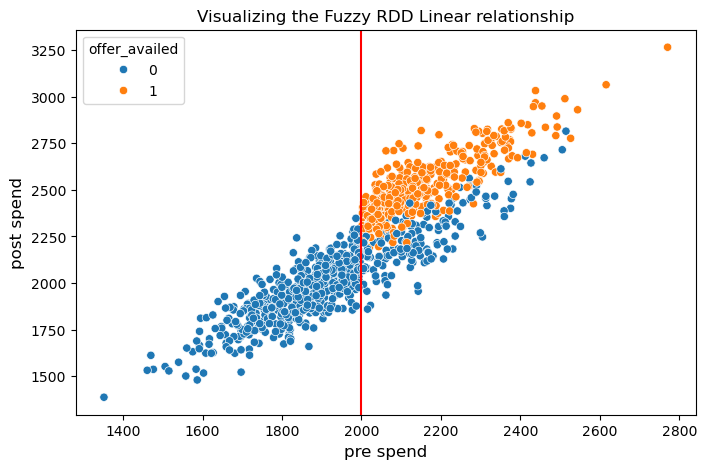

In [983]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data = df3, x = 'pre_spend', y = 'post_spend', hue = 'offer_availed');
plt.axvline(x=2000, color = 'red');
plt.title('Visualizing the Fuzzy RDD Linear relationship')
plt.xlabel('pre spend', fontsize=12)
plt.ylabel('post spend', fontsize=12)
plt.show()

In [985]:
bandwidth_opt = rdd.optimal_bandwidth(df3['post_spend'], df3['pre_spend'], cut=2000)
print("Optimal bandwidth:", bandwidth_opt)

Optimal bandwidth: 20.774142639171497


In [987]:
data_rdd = rdd.truncated_data(df3, 'pre_spend', bandwidth_opt, cut=2000)

In [989]:
itte = smf.wls("post_spend~pre_spend+cutoff", data_rdd, weights=kernel(data_rdd['pre_spend'], cut=2000, h = bandwidth_opt)).fit()
itte.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:             post_spend   R-squared:                       0.295
Model:                            WLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     18.63
Date:                Sun, 06 Oct 2024   Prob (F-statistic):           1.74e-07
Time:                        19:50:37   Log-Likelihood:                -581.99
No. Observations:                  92   AIC:                             1170.
Df Residuals:                      89   BIC:                             1178.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3656.1032   5503.822      0.664      0.508   -7279.873    1.46e+04
pre_spend     -0.7715      2.762     -0.279      0.781      -6.260       4.717
cutoff       166.5371     48.548      3.430      0.001      70.074     263.000
==============================================================================
Omnibus:                        5.321   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                4.819
Skew:                          -0.551   Prob(JB):                       0.0898
Kurtosis:                       3.203   Cond. No.                     8.66e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [991]:
compliance = smf.wls("offer_availed~pre_spend+cutoff", data_rdd, weights=kernel(data_rdd['pre_spend'], cut=2000, h = bandwidth_opt)).fit()
compliance.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:          offer_availed   R-squared:                       0.544
Model:                            WLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     53.09
Date:                Sun, 06 Oct 2024   Prob (F-statistic):           6.66e-16
Time:                        19:50:41   Log-Likelihood:                -36.877
No. Observations:                  92   AIC:                             79.75
Df Residuals:                      89   BIC:                             87.32
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.1371     14.703      1.302      0.196     -10.078      48.352
pre_spend     -0.0096      0.007     -1.302      0.196      -0.024       0.005
cutoff         0.8378      0.130      6.460      0.000       0.580       1.096
==============================================================================
Omnibus:                       22.578   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.392
Skew:                          -1.234   Prob(JB):                     4.15e-07
Kurtosis:                       4.257   Cond. No.                     8.66e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [993]:
LATE = itte.params['cutoff']/compliance.params['cutoff']
LATE

198.7705046182621

In [1001]:
# if compliance rate is 70%, same as simulated
print(f'LATE = {166/0.7}')

LATE = 237.14285714285717


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


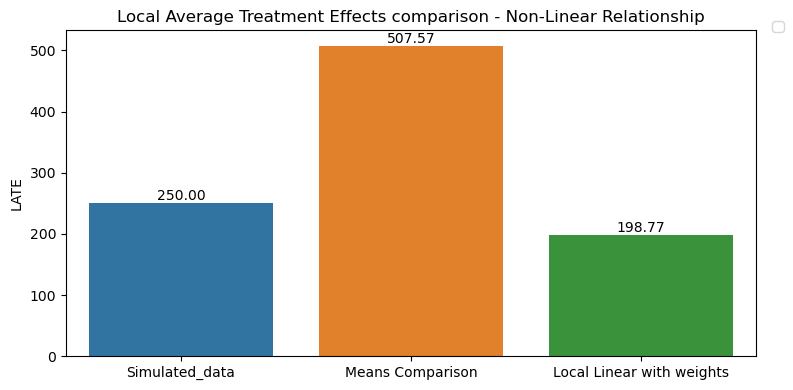

In [1003]:
# Plot comparison of results

categories = ['Simulated_data', 'Means Comparison', 'Local Linear with weights']
plt.figure(figsize = (8,4))
ax = sns.barplot(x=categories, y=[250, diff_in_mean, LATE], hue = categories)

for p in ax.patches:
    label = "{:.2f}".format(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(label, (x, y), ha="center", va="center", 
                size=10, xytext=(0, 5), textcoords="offset points",) 
    
plt.ylabel('LATE')
plt.title('Local Average Treatment Effects comparison - Non-Linear Relationship')
plt.legend(bbox_to_anchor = (1.05, 1.05))
plt.tight_layout()
plt.show()

Text(0.5, 0, 'Pre spend')

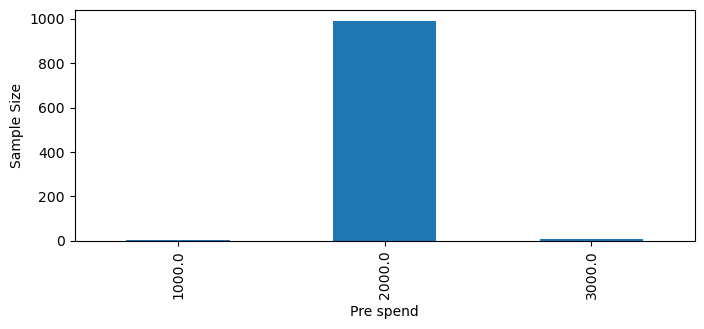

In [1015]:
plt.figure(figsize=(8,3))
df3.round({"pre_spend":-3}).groupby("pre_spend").size().plot.bar()
plt.ylabel("Sample Size")
plt.xlabel("Pre spend")